"Joshi" at any point of code or comments refers to **Pratik Joshi, Sebastin Santy, Amar Budhiraja, Kalika Bali, and Monojit Choudhury. 2020. The state and fate of linguistic diversity and inclusion in the NLP world. In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics, pages 6282–6293, Online. Association for Computational Linguistics.**

# Mount the Google drive 

In [1]:
from google.colab import drive

try:
  drive.mount('/content/gdrive')
  pathBase="/content/gdrive/MyDrive/Research/AACL Sinhala Paper/"  
except:
  print("Load the drive manually from the left panel first. Then run this again,")
  pathBase="/content/drive/MyDrive/Research/AACL Sinhala Paper/"  

pathFull=pathBase+"Final Official Github Repo/"
dataPath=pathFull+"Data/"
inputPath=dataPath+"Input/"
outputPath=dataPath+"Output/"

pathI=outputPath+"images/"
pathT=outputPath+"tables/"
pathJ=outputPath+"json/"
pathC=outputPath+"outCSVs/"

Mounted at /content/gdrive


# Define the colour schemes

In [2]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colourNames=["#FFCCCC","#FF8888","#FF4444","#FF0000","#CCFFCC","#88FF88","#44FF44","#00FF00","#CCCCFF","#8888FF","#4444FF","#0000FF"]
jcolourNames=["green","blue","purple","yellow","orange","red"]
geoClourNames=colourNames+colourNames

newcmp = ListedColormap(colourNames)
jcmp = ListedColormap(jcolourNames)
gcmp=ListedColormap(geoClourNames)

# Define Ethnolog Axis sorting order for visualizations

In [14]:
sizeArr=['Small','Mid','Large']
vitalityArr=['Extinct','Endangered','Stable','Institutional']

# Load the inputs

## Main CSV

In [3]:
import pandas as pd

data=pd.read_csv(inputPath+"language data - ethnologue languages.csv", thousands=',') 

In [4]:
data.columns # Verify the data columns

Index(['Name', 'ethnolog_Size', 'ethnolog_Vitality', 'L1 speakers',
       'L2 speakers', 'New wiki', 'Size of Wikipedia (Articles Column)',
       'language family', 'geographical location', 'geo location analysis',
       'LDC', 'Is in Google', 'wiki pages', 'natural language processing',
       'part of speech', 'grammar parsing| grammar parser',
       'question answering', 'text classification', 'universal dependencies',
       'ACL count', 'Is in XLMR', 'ELRA', 'Hugginface', 'kaggle', 'CC Size',
       'Is in Facebook', 'Joshi Classes', 'mBERT', 'HF new'],
      dtype='object')

In [5]:
# Drop the sections that we are not going to use in visualizations 

data=data.drop(index=[0,1])
data=data.drop(['kaggle',  'natural language processing', 'part of speech',
       'grammar parsing| grammar parser', 'question answering',
       'text classification'], axis=1)

In [6]:
# Some of our ethnolog class annotations had to be fixed

def capitalizeColumn(c):
  data[c]= [s.title() if type(s)==str else s for s in data[c].tolist()]


capitalizeColumn("ethnolog_Size")
capitalizeColumn("ethnolog_Vitality")

In [7]:
# Fill the sparsley filled XLMR and mBERT columns. 

XLMRandBERT=['Is in XLMR','mBERT']

for c in XLMRandBERT:
  data[c]=pd.to_numeric(data[c],errors='coerce')
  data[c]=data[c].fillna(0)

# Since we are considering them together, create a new column with the sum  

data["XLMR+mBERT"]= data[XLMRandBERT].sum(axis=1) #Rows sum 

In [9]:
# Eliminate cases where the Ethnolog data cannot be found. 
# Note: No need to do it agoing for ethnolog_Vitality because the availablity of data goes hand in hand

data=data.dropna(subset=['ethnolog_Size'])

In [10]:
# Our annotators had put spaces in the Google column. It was easier to fix it in code rather than going and editing the source again

data['Is in Google']=data['Is in Google'].fillna(0)
data['Is in Google']=pd.to_numeric(data['Is in Google'],errors='coerce')
data['Is in Google']=data['Is in Google'].fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [11]:
# Clean up the Joshi class column by assigning -1 to languages where Joshi has not assigned a class

data['Joshi Classes']=data['Joshi Classes'].fillna(-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Create intermediary data structures

In [12]:
def makeD():
  d={}
  for s in list(set(data.ethnolog_Size)):
    d[s]={}
    for v in list(set(data.ethnolog_Vitality)):
      d[s][v]=data[(data.ethnolog_Size==s) & (data.ethnolog_Vitality	==v)]
  return(d)

d=makeD()

In [15]:
# Calculate the max while printing basic counts for reference

m=0

for s in d:
  for v in d[s]:
    num=len(d[s][v])
    m=max(m,num)
    print(s+" "+v+": "+str(num))

Mid Endangered: 458
Mid Extinct: 0
Mid Stable: 1700
Mid Institutional: 208
Large Endangered: 14
Large Extinct: 0
Large Stable: 133
Large Institutional: 217
Small Endangered: 2162
Small Extinct: 332
Small Stable: 1168
Small Institutional: 28


In [16]:
# Added this at the very end because Arxiv didn't like spaces or paranthises

def makeFileNameArxivSafe(s):
  return(s.replace(" ","_").replace("(","_").replace(")","_"))

# Draw Bubble Graphs

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

x=[]
y=[]
area=[]
colors =[]
eColors=[]
labels=[]
vitalityArrRev=[v for v in vitalityArr]
vitalityArrRev.reverse()

def addPoint(s,v,a,c,ec):
  x.append(v)
  y.append(s)
  area.append(a) 
  colors.append(c)
  eColors.append(ec)

def addseries(series):
  for s in d:
    yAx=sizeArr.index(s)
    for v in d[s]:
      xAx=vitalityArrRev.index(v)
      cut=d[s][v]
      if(series is None):   
        addPoint(yAx,xAx,(3500*len(cut))/m,'white','blue') 
      else:
        cut=cut.dropna(subset=[series])  #Drop NaN
        cut = cut[cut[series] != 0]  #Drop zero 
        per=len(cut)/m
        addPoint(yAx,xAx,3500*per,'red','red')


def plotBubbleGraph(series):
  plt.figure(figsize=(4, 3), dpi=100)
  global x,y,area,colors,eColors,labels 
  x=[]
  y=[]
  area=[]
  colors =[]
  eColors=[]
  labels=[]

  fileName="bubbleplot"
  addseries(None)  # First draw the language bubbles in blue
  if series!=None:
    addseries(series) # Now draw the coloumn data in red
    fileName=fileName+"_"+series
  
  plt.xticks(range(len(vitalityArrRev)),vitalityArrRev)
  plt.yticks(range(len(sizeArr)), sizeArr)

  plt.scatter(x, y, s=area, c=colors, alpha=0.5,edgecolors=eColors)
  plt.margins(x=0.1,y=0.3)

  plt.savefig(pathI+makeFileNameArxivSafe(fileName)+'.png',bbox_inches='tight', dpi=500)

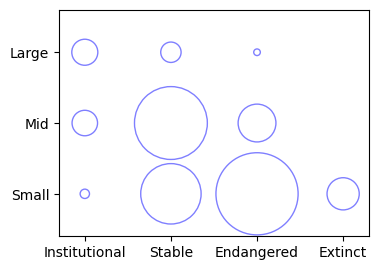

In [18]:
# Draw the empty bubble baseline

plotBubbleGraph(None)

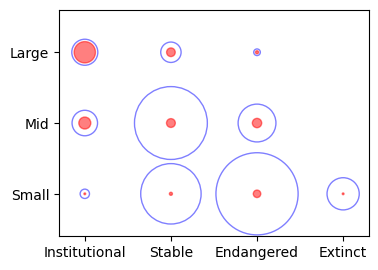

In [19]:
plotBubbleGraph('Size of Wikipedia (Articles Column)')

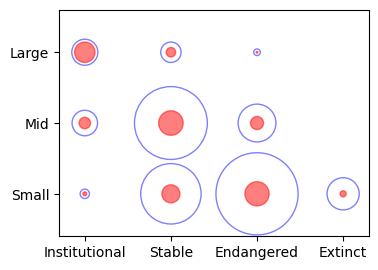

In [20]:
plotBubbleGraph('ACL count')

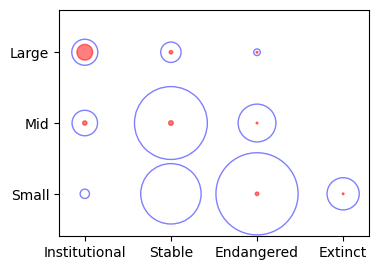

In [21]:
plotBubbleGraph('LDC')

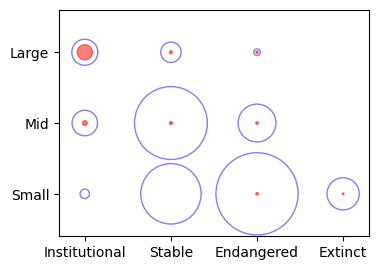

In [22]:
plotBubbleGraph('ELRA')

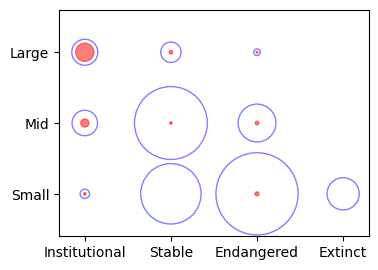

In [23]:
plotBubbleGraph('CC Size')

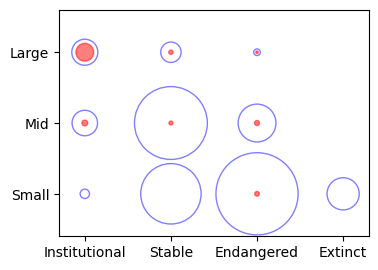

In [24]:
plotBubbleGraph('Is in Facebook') 

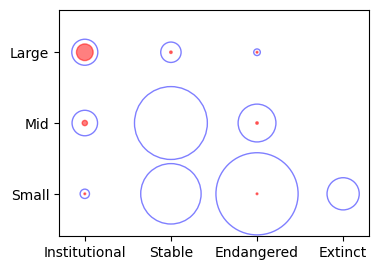

In [25]:
plotBubbleGraph('Is in Google')  

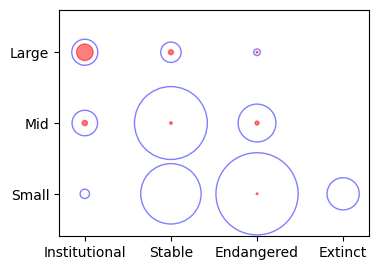

In [26]:
plotBubbleGraph('XLMR+mBERT')

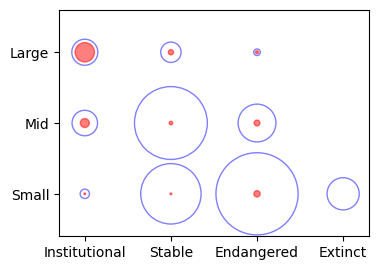

In [27]:
plotBubbleGraph('Hugginface') 